<a href="https://colab.research.google.com/github/SachinLamichhane/Tuberculosis-detection/blob/main/benchmarkXAIdiabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
pip install beexai

In [18]:
!git clone https://github.com/SquareResearchCenter-AI/BEExAI.git

Cloning into 'BEExAI'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 301 (delta 95), reused 244 (delta 50), pack-reused 0 (from 0)
Receiving objects: 100% (301/301), 37.41 MiB | 12.03 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [19]:
%cd BEExAI

/content/BEExAI/BEExAI


In [20]:
!pip install -r requirements.txt

In [28]:
import pandas as pd
Dataset = pd.read_csv('/content/drive/MyDrive/diabetes.csv')
Dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [29]:
import yaml

# Define the configuration as a Python dictionary
config_data = {
    "path": "/content/drive/MyDrive/diabetes.csv",  # Corrected key with quotes
    "target_col": "Outcome",                       # Corrected key with quotes
    "cleaned_data_path": "/content/BEExAI/output/data/diabetes.csv",
    "task": "classification"
}

# Write the configuration to a YAML file
config_path = "/content/BEExAI/config/diabetes.yml"
with open(config_path, "w") as file:
    yaml.dump(config_data, file, default_flow_style=False)

print(f"Config file saved successfully at {config_path}")

Config file saved successfully at /content/BEExAI/config/diabetes.yml


In [30]:
import sys
sys.path.append('/content/BEExAI/src')

In [31]:
from beexai.dataset.load_data import load_data

# Define the path to the configuration file
CONFIG_PATH = "config/diabetes.yml"

# Load the dataset, target column, and task type using the configuration file
data_test, target_col, task, _ = load_data(
    from_cleaned=False,
    config_path=CONFIG_PATH,
    keep_corr_features=True
)

# Display the loaded data, target column, and task type
print("Data Test Sample:")
print(data_test.head())

print("Target Column:", target_col)
print("Task:", task)

Data Test Sample:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Target Column: Outcome
Task: classification


In [35]:
from beexai.dataset.dataset import Dataset
data = Dataset(data_test, target_col)
scale_params = {
    "x_num_scaler_name": "quantile_normal",
    "x_cat_encoder_name": "ordinalencoder",
    "y_scaler_name": "labelencoder",  # change to minmax or another float scaler for regression
    "cat_not_to_onehot": ["name"],
}
X_train, X_test, y_train, y_test = data.get_train_test(
    test_size=0.2, scaler_params=scale_params
)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_samples.
  warnings.warn(


Using device: cpu


Loss: 0.364: 100%|██████████| 1000/1000 [04:04<00:00,  4.08it/s]


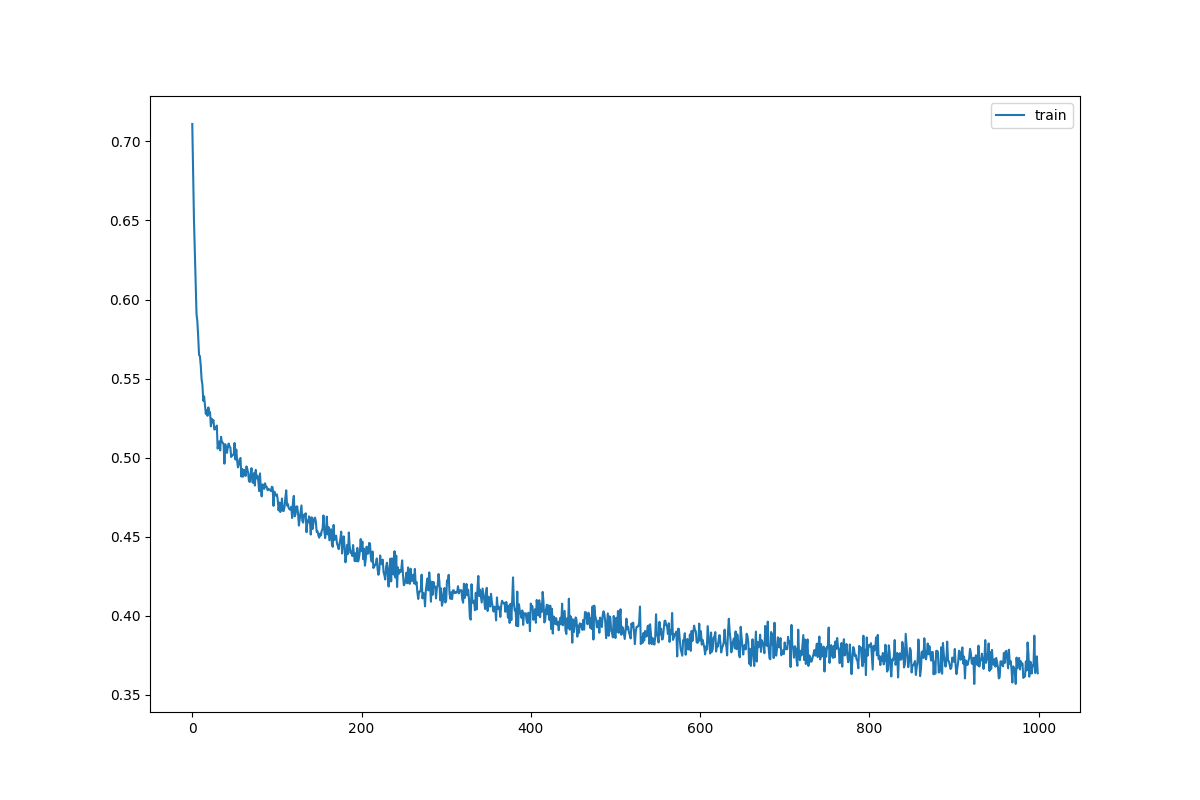

In [43]:
from beexai.training.train import Trainer
import os
import torch

# Check if GPU is available; otherwise, fallback to CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Define dataset and model details
DATA_NAME = "diabetes"
MODEL_NAME = "NeuralNetwork"
CONFIG_PATH = f"/content/BEExAI/config/{DATA_NAME}.yml"

# Determine the number of output labels based on the task type
NUM_LABELS = data.get_classes_num(task)

# Define Neural Network parameters
NN_PARAMS = {"input_dim": X_train.shape[1], "output_dim": NUM_LABELS}

# Initialize the Trainer with the selected model
trainer = Trainer(MODEL_NAME, task, NN_PARAMS, device=device)

# Define the path to the output directory
output_dir = "/content/BEExAI/output"

# Create the directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Define the path to save the loss file
loss_file = os.path.join(output_dir, "loss.png")

# Train the model and save the loss curve
trainer.train(X_train, y_train, loss_file=loss_file)

from IPython.display import Image, display

# Display the saved loss curve
display(Image(filename=loss_file))

In [44]:
trainer.model.eval()  # comment if not using NN

metrics = trainer.get_metrics(X_test, y_test)
for k, v in metrics.items():
    print(k, v)

accuracy 0.7272727272727273
f1 score 0.7301048951048951


In [45]:
import os

# Define the output directory for models
model_dir = "/content/drive/MyDrive/Models"

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# Define the file name for the saved model
model_file = os.path.join(model_dir, "diabetes_model.pt")

# Save the model
trainer.save_model(model_file)

print(f"Model saved successfully at: {model_file}")

Model saved successfully at: /content/drive/MyDrive/Models/diabetes_model.pt


In [46]:
import os

output_dir = "../output/explain/"
os.makedirs(output_dir, exist_ok=True)

In [49]:
from beexai.evaluate.metrics.get_results import get_all_metrics
from beexai.explanation.explaining import CaptumExplainer
METHOD = "IntegratedGradients"  # change this to a Non-Gradient based method for sklearn models
explainer = CaptumExplainer(
    trainer.model, task=task, method="IntegratedGradients", sklearn=False, device=device
)  # for sklearn models, change sklearn=False to True

explainer.init_explainer()
all_preds = trainer.model.predict(X_test.values)
attributions = explainer.compute_attributions(
    X_test,
    DATA_NAME,
    MODEL_NAME,
    METHOD,
    "/content/BEExAI/output/explain/attributions/diabetes",
    all_preds,
    save=True,
    use_abs=False,  # change this to True for regression (more details in the paper)
)
print("CaptumExplainer imported successfully.")

In [50]:
import pickle

# Define the path to the .pkl file
pkl_file_path = "/content/BEExAI/output/explain/attributions/diabetes/attributions/diabetes/NeuralNetwork_IntegratedGradients.pkl"

# Load the .pkl file
with open(pkl_file_path, "rb") as file:
    attributions = pickle.load(file)

# Print a summary of the contents
print("Loaded Attributions:")
print(attributions)
if isinstance(attributions, dict):
    print("Keys:", attributions.keys())
elif isinstance(attributions, list):
    print("First Entry:", attributions[0])


Loaded Attributions:
tensor([[-1.2623e-07,  1.8256e-05,  3.3818e-06,  ..., -9.5634e-07,
          6.4683e-06,  5.5496e-07],
        [ 6.4546e-06, -1.1673e-04,  2.1291e-06,  ...,  2.4578e-05,
         -1.1377e-04,  2.1266e-04],
        [ 5.1683e-03,  6.3127e-02,  2.4363e-02,  ...,  3.0168e-03,
         -5.5166e-03, -9.0612e-03],
        ...,
        [-1.8483e-07, -1.8118e-06, -1.5405e-06,  ..., -1.9283e-06,
         -2.9327e-05,  2.1030e-05],
        [ 4.5129e-04,  7.0869e-02, -1.3161e-03,  ..., -2.1855e-03,
          1.0268e-02, -1.0561e-02],
        [ 3.0548e-04,  5.6650e-03, -2.0159e-04,  ..., -1.8275e-03,
          3.9608e-04, -2.0108e-04]])


In [51]:
import importlib.util
spec = importlib.util.spec_from_file_location(
    "CaptumExplainer", "/content/BEExAI/src/beexai/explanation/explaining.py"
)
explaining = importlib.util.module_from_spec(spec)
spec.loader.exec_module(explaining)

# Access the class
CaptumExplainer = explaining.CaptumExplainer

In [52]:
from beexai.explanation.explaining import CaptumExplainer
from beexai.evaluate.metrics.get_results import get_all_metrics

METHOD = "IntegratedGradients"
exp = CaptumExplainer(trainer.model,task=task,method=METHOD,sklearn=False)
exp.init_explainer()

LABEL=0

get_all_metrics(X_test.values,LABEL,trainer.model,exp)

compute_faith_corr took 0.04146170616149902 seconds
compute_inf took 0.08327889442443848 seconds


/content/BEExAI/src/beexai/evaluate/metrics/infidelity.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stds = torch.tensor(self.std, device=self.device).float()
/content/BEExAI/src/beexai/evaluate/metrics/sensitivity.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  radius = torch.tensor(self.radius, device=self.device)


compute_sens took 4.063234806060791 seconds
compute_comp took 0.0035550594329833984 seconds
compute_suff took 0.002895832061767578 seconds
compute_mono took 0.016591310501098633 seconds
compute_auc took 0.004465818405151367 seconds
compute_complex took 0.00125885009765625 seconds
compute_spar took 0.0009605884552001953 seconds


,FaithCorr,Infidelity,Sensitivity,Comprehensiveness,Sufficiency,Monotonicity,AUC_TP,Complexity,Sparseness
0,0.269011,0.482584,0.303641,0.135963,-0.274912,0.571429,0.211445,0.184178,0.558057


In [61]:
!python benchmetrics.py --config_path /content/BEExAI/config/diabetes.yml \
                        --save_path /content/BEExAI/benchmark_results \
                         --methods SHAP,LIME \
                        --seed 42 \
                        --n_sample 500


Device: cpu


In [59]:
!ls /content/drive/MyDrive/Models/attributions
